1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [7]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

Eigenvalues: [2.65753046e+01+0.j 3.61896094e-15+0.j 2.04008713e+00+0.j]
Eigenvectors:
 [[-0.11768679 -0.81649658  0.56522841]
 [-0.57457381 -0.40824829 -0.7093647 ]
 [-0.80994738  0.40824829  0.42109212]]
Eigenvalues with SVD: [2.65755977e+01 2.04453443e+00 2.97021153e-31]
Eigenvectors with SVD:
 [[-0.11766048  0.56523388 -0.81649658]
 [-0.57460682 -0.70933795 -0.40824829]
 [-0.80992778  0.42112982  0.40824829]]
 variability = 1.0


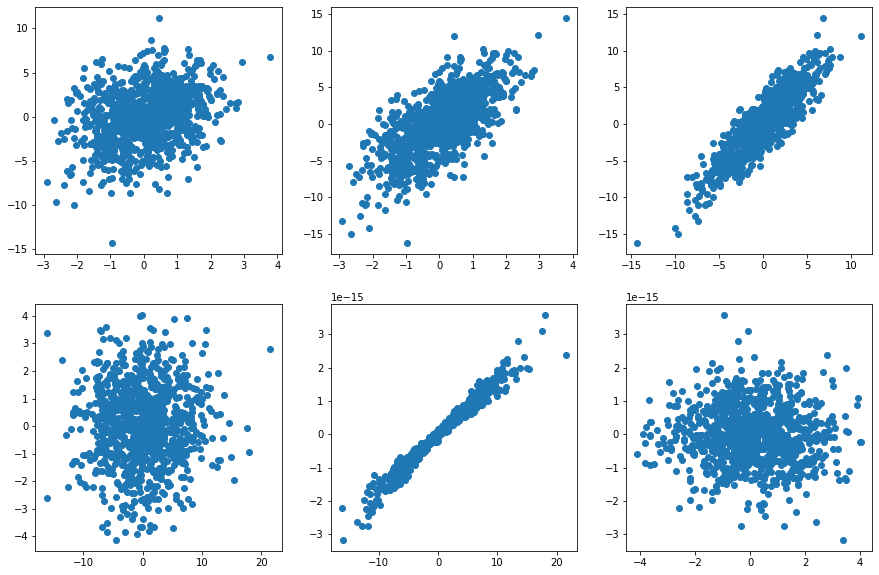

In [16]:
N = 1000
x1 = np.random.normal(0.0, 1.0, N)
x2 = x1 + np.random.normal(0.0, 3.0, N)
x3 = 2*x1 + x2
X  = np.array([x1, x2, x3])

eVal_pca, eVec_pca = la.eig(np.cov(X))
print("Eigenvalues:", eVal_pca)
print("Eigenvectors:\n", eVec_pca)

U, spectrum, Vt = la.svd(X)
eVal_svd = spectrum**2/(N-1)
eVec_svd = U
print("Eigenvalues with SVD:", eVal_svd)
print("Eigenvectors with SVD:\n", eVec_svd)
print(" variability =", (eVal_svd[0]+eVal_svd[1])/np.sum(eVal_svd))
Xp = np.dot(eVec_svd.T, X)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax[0,0].scatter(X[0], X[1])
ax[0,1].scatter(X[0], X[2])
ax[0,2].scatter(X[1], X[2])
ax[1,0].scatter(Xp[0], Xp[1])
ax[1,1].scatter(Xp[0], Xp[2])
ax[1,2].scatter(Xp[1], Xp[2])

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

Eigenvalues: [2.68130896e+01+0.j 1.11620995e-03+0.j 1.81562563e+00+0.j]
Eigenvectors:
 [[-0.12084406 -0.81642811  0.56466083]
 [-0.57087028 -0.40819887 -0.71237687]
 [-0.81209842  0.4084346   0.41674613]]
Eigenvalues with SVD: [2.69382851e+01 1.81580647e+00 1.11663814e-03]
Eigenvectors with SVD:
 [[-0.1209583   0.56464184 -0.81642433]
 [-0.57073853 -0.71248327 -0.40819741]
 [-0.81217401  0.41658995  0.40844362]]
variability = 0.9999611674470551


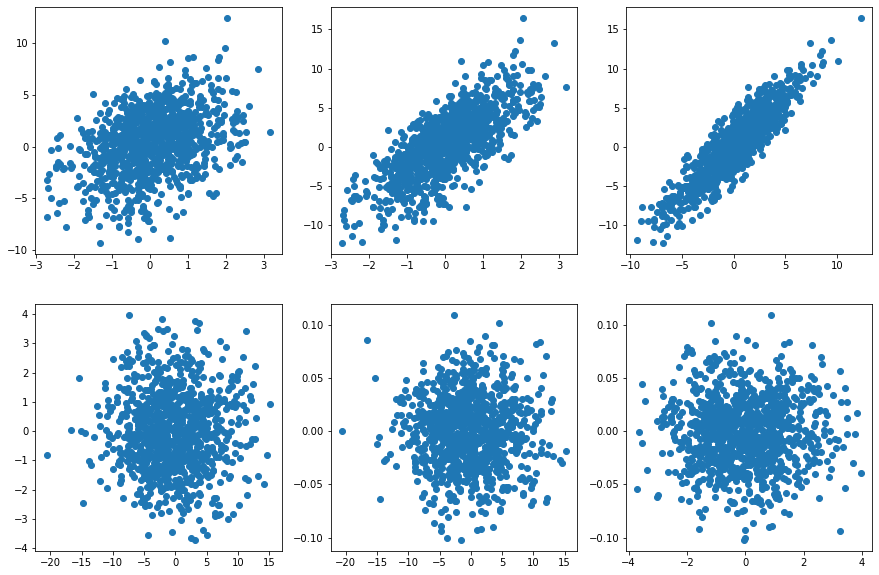

In [15]:
random_var = np.random.rand(10) / 50
N = 1000
x1 = np.random.randn(N)
x2 = x1 + 3*np.random.randn(N)
x3 = 2*x1 + x2
for sigma in random_var:
    x1 += np.random.randn(N)*sigma
    x2 += np.random.randn(N)*sigma
    x3 += np.random.randn(N)*sigma
X  = np.array([x1, x2, x3])
eVal_pca, eVec_pca = la.eig(np.cov(X))
print("Eigenvalues:", eVal_pca)
print("Eigenvectors:\n", eVec_pca)
U, spectrum, Vt = la.svd(X)
eVal_svd = spectrum**2/(N-1)
eVec_svd = U
print("Eigenvalues with SVD:", eVal_svd)
print("Eigenvectors with SVD:\n", eVec_svd)
print("variability =", (eVal_svd[0]+eVal_svd[1])/np.sum(eVal_svd))
Xp = np.dot(eVec_svd.T, X)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
ax[0,0].scatter(X[0], X[1])
ax[0,1].scatter(X[0], X[2])
ax[0,2].scatter(X[1], X[2])
ax[1,0].scatter(Xp[0], Xp[1])
ax[1,1].scatter(Xp[0], Xp[2])
ax[1,2].scatter(Xp[1], Xp[2])

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [ ]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 